# we need to create a general dataset, this has a few main steps

This will load in sequences, then apply preprocessing in the wayy david kelley does it with the scaling, shifting and whatever else he does. Then we will also do the unmappable regions

If needed we can prcompute the filled in values or whatever, let's review what he does an dmake sure it makes sense

In [1]:
#so first of all, there is this unmap_human.bed, so we can simply turn that into a np array that is by genome and load it in in its entirity. Just 3 GB, let's do that!

import pandas as pd
import numpy as np

unmap_human = pd.read_csv("/data1/lesliec/sarthak/data/borzoi/umap_human.bed", sep="\t", header=None)
unmap_human.head()

,0,1,2
0,chr1,0,10146
1,chr1,10258,10312
2,chr1,10352,10435
3,chr1,10468,13293
4,chr1,13358,13946


In [7]:
#find unique values for column 0
chromosomes = unmap_human[0].unique()
chromosomes

array(['chr1', 'chr10', 'chr10_KI270824v1_alt', 'chr11',
       'chr11_KI270903v1_alt', 'chr12', 'chr12_GL877875v1_alt',
       'chr12_KI270835v1_alt', 'chr13', 'chr13_KI270840v1_alt', 'chr14',
       'chr14_GL000009v2_random', 'chr14_GL000194v1_random',
       'chr14_GL000225v1_random', 'chr14_KI270722v1_random',
       'chr14_KI270723v1_random', 'chr14_KI270724v1_random',
       'chr14_KI270725v1_random', 'chr15', 'chr15_KI270727v1_random',
       'chr15_KI270850v1_alt', 'chr15_KI270852v1_alt',
       'chr15_KI270905v1_alt', 'chr16', 'chr16_KI270728v1_random',
       'chr16_KI270853v1_alt', 'chr17', 'chr17_GL000205v2_random',
       'chr17_GL383563v3_alt', 'chr17_KI270729v1_random',
       'chr17_KI270730v1_random', 'chr18', 'chr19',
       'chr19_GL383573v1_alt', 'chr19_GL383576v1_alt',
       'chr19_GL949746v1_alt', 'chr19_GL949747v2_alt',
       'chr19_GL949748v2_alt', 'chr19_GL949749v2_alt',
       'chr19_GL949750v2_alt', 'chr19_GL949751v2_alt',
       'chr19_GL949752v1_alt', 'ch

In [2]:
#let's just make it a np array of values
umap_chr1 = np.zeros(248956422)
for i in range(unmap_human.shape[0]):
    if unmap_human.iloc[i, 0] == "chr1":
        umap_chr1[unmap_human.iloc[i, 1]:unmap_human.iloc[i, 2]] = 1

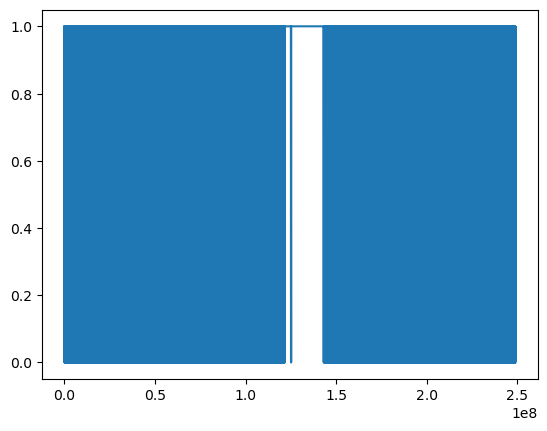

In [ ]:
#this process is actually pretty slow lol, but it's fine? let's test it now
import matplotlib.pyplot as plt
plt.plot(umap_chr1) #this literally doesn't tell us anything lmao!!

In [ ]:
umap_chr1.sum()/len(umap_chr1) #16% of the genome is unmappable, that's extremely high, at least for chr1!

0.16038682464676488

In [8]:
#let's compare witht he other human bed file
unmap_human2 = pd.read_csv("/data1/lesliec/sarthak/data/borzoi/umap_k36_t10_l32_hg38.bed", sep="\t", header=None)
unmap_human2.head()

,0,1,2
0,chr1,0,10146
1,chr1,10258,10312
2,chr1,10352,10435
3,chr1,10471,10589
4,chr1,10654,10783


In [ ]:
unmap_human2[0].unique() #this is the same as the other one, but seems to just be a reduced value of them

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX', 'chrY'], dtype=object)

In [ ]:
unmap_human.shape, unmap_human2.shape #they are not the same, that's strange. Seems simlar tho, let's see where we got it from.
#it seems they download both. LEt's see what's used in the makefile
#so they seem to use this weird name one alongwith the blacklist and then used bedtools to merge them!



((1472317, 3), (1522122, 3))

In [ ]:
#another option is make sure that unmap_human2 is entirely contained within unmap_human
umap_chr1_2 = np.zeros(248956422)
for i in range(unmap_human2.shape[0]):
    if unmap_human2.iloc[i, 0] == "chr1":
        umap_chr1_2[unmap_human2.iloc[i, 1]:unmap_human2.iloc[i, 2]] = 1
print(umap_chr1_2.sum()/len(umap_chr1_2)) #this is 15.9%, so it's just a bit less

0.15896259948658806


In [ ]:
#now make sure it's contained
diff = umap_chr1 - umap_chr1_2 #this is all 0, so it's contained
#the difference should be either 0 or 1, if it's negative then there's wrong ones
diff.min(), diff.max() #yup it's as expected, just more values, because contains blacklist, so let's use this for the unmappable

(0.0, 1.0)

In [ ]:
#so u se the umap_human.bed and create the full list

In [15]:
#we can save it for all the different chromosomes using np.savez
chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22','chrX', 'chrY']
umap = {}
for chrom in chroms:
    umap[chrom] = np.zeros(248956422, dtype=np.uint8)
    for i in range(unmap_human.shape[0]):
        if unmap_human.iloc[i, 0] == chrom:
            umap[chrom][unmap_human.iloc[i, 1]:unmap_human.iloc[i, 2]] = 1
    a = umap[chrom].sum()/len(umap[chrom])
    print('Chromosome:', chrom, 'Percentage:',a)
# np.save(f"/data1/lesliec/sarthak/data/borzoi/umap_{chrom}.npy", umap[chrom])

Chromosome: chr1 Percentage: 0.16038682464676488
Chromosome: chr2 Percentage: 0.07407372283009434
Chromosome: chr3 Percentage: 0.04965291074114168
Chromosome: chr4 Percentage: 0.04782573152501364
Chromosome: chr5 Percentage: 0.06119281389736554
Chromosome: chr6 Percentage: 0.043103302633422325
Chromosome: chr7 Percentage: 0.06528848249594461
Chromosome: chr8 Percentage: 0.043645726881470046
Chromosome: chr9 Percentage: 0.1326802045700994
Chromosome: chr10 Percentage: 0.04530081573874804
Chromosome: chr11 Percentage: 0.048350727020008345
Chromosome: chr12 Percentage: 0.040556435214191826
Chromosome: chr13 Percentage: 0.09097160787440944
Chromosome: chr14 Percentage: 0.09506335209139534
Chromosome: chr15 Percentage: 0.11278987211665502
Chromosome: chr16 Percentage: 0.07818539021258909
Chromosome: chr17 Percentage: 0.04571814178788286
Chromosome: chr18 Percentage: 0.035868213112413706
Chromosome: chr19 Percentage: 0.033751127737528294
Chromosome: chr20 Percentage: 0.02687380364102437
Chro

In [16]:
#now let's save it
np.savez("/data1/lesliec/sarthak/data/borzoi/umap.npz", **umap)

In [ ]:
#let's load it in
loaded = np.load("/data1/lesliec/sarthak/data/borzoi/umap.npz")
umap_swapped = {chrom: ~loaded[chrom] & 1 for chrom in loaded.files}
#ok 6 seconds to load it and swap it, that's fine

In [18]:
#now let's verify it's actually swapped
for chrom in chroms:
    print('Chromosome:', chrom, 'Percentage:',umap_swapped[chrom].sum()/len(umap_swapped[chrom]))

Chromosome: chr1 Percentage: 0.8396131753532351
Chromosome: chr2 Percentage: 0.9259262771699056
Chromosome: chr3 Percentage: 0.9503470892588584
Chromosome: chr4 Percentage: 0.9521742684749863
Chromosome: chr5 Percentage: 0.9388071861026345
Chromosome: chr6 Percentage: 0.9568966973665777
Chromosome: chr7 Percentage: 0.9347115175040553
Chromosome: chr8 Percentage: 0.9563542731185299
Chromosome: chr9 Percentage: 0.8673197954299006
Chromosome: chr10 Percentage: 0.954699184261252
Chromosome: chr11 Percentage: 0.9516492729799917
Chromosome: chr12 Percentage: 0.9594435647858082
Chromosome: chr13 Percentage: 0.9090283921255906
Chromosome: chr14 Percentage: 0.9049366479086046
Chromosome: chr15 Percentage: 0.887210127883345
Chromosome: chr16 Percentage: 0.9218146097874109
Chromosome: chr17 Percentage: 0.9542818582121171
Chromosome: chr18 Percentage: 0.9641317868875863
Chromosome: chr19 Percentage: 0.9662488722624717
Chromosome: chr20 Percentage: 0.9731261963589757
Chromosome: chr21 Percentage: 0

In [19]:
for chrom in chroms:
    print('Chromosome:', chrom, 'Percentage:',umap_swapped[chrom].sum()/len(umap_swapped[chrom]), 'Original:', umap[chrom].sum()/len(umap[chrom]), 'Sum:', (umap[chrom].sum()+umap_swapped[chrom].sum())/len(umap[chrom]))

Chromosome: chr1 Percentage: 0.8396131753532351 Original: 0.16038682464676488 Sum: 1.0
Chromosome: chr2 Percentage: 0.9259262771699056 Original: 0.07407372283009434 Sum: 1.0
Chromosome: chr3 Percentage: 0.9503470892588584 Original: 0.04965291074114168 Sum: 1.0
Chromosome: chr4 Percentage: 0.9521742684749863 Original: 0.04782573152501364 Sum: 1.0
Chromosome: chr5 Percentage: 0.9388071861026345 Original: 0.06119281389736554 Sum: 1.0
Chromosome: chr6 Percentage: 0.9568966973665777 Original: 0.043103302633422325 Sum: 1.0
Chromosome: chr7 Percentage: 0.9347115175040553 Original: 0.06528848249594461 Sum: 1.0
Chromosome: chr8 Percentage: 0.9563542731185299 Original: 0.043645726881470046 Sum: 1.0
Chromosome: chr9 Percentage: 0.8673197954299006 Original: 0.1326802045700994 Sum: 1.0
Chromosome: chr10 Percentage: 0.954699184261252 Original: 0.04530081573874804 Sum: 1.0
Chromosome: chr11 Percentage: 0.9516492729799917 Original: 0.048350727020008345 Sum: 1.0
Chromosome: chr12 Percentage: 0.95944356

In [ ]:
#one other way to test is simply to find the difference
for chrom in chroms:
    print('Chromosome:', chrom, 'Difference:', np.abs((umap[chrom] - umap_swapped[chrom])).max(), np.abs((umap[chrom] - umap_swapped[chrom])).min()) #should be 1 always
#wait why is difference 255??

Chromosome: chr1 Difference: 255 1
Chromosome: chr2 Difference: 255 1
Chromosome: chr3 Difference: 255 1
Chromosome: chr4 Difference: 255 1
Chromosome: chr5 Difference: 255 1
Chromosome: chr6 Difference: 255 1
Chromosome: chr7 Difference: 255 1
Chromosome: chr8 Difference: 255 1
Chromosome: chr9 Difference: 255 1
Chromosome: chr10 Difference: 255 1
Chromosome: chr11 Difference: 255 1
Chromosome: chr12 Difference: 255 1
Chromosome: chr13 Difference: 255 1
Chromosome: chr14 Difference: 255 1
Chromosome: chr15 Difference: 255 1
Chromosome: chr16 Difference: 255 1
Chromosome: chr17 Difference: 255 1
Chromosome: chr18 Difference: 255 1
Chromosome: chr19 Difference: 255 1
Chromosome: chr20 Difference: 255 1
Chromosome: chr21 Difference: 255 1
Chromosome: chr22 Difference: 255 1
Chromosome: chrX Difference: 255 1
Chromosome: chrY Difference: 255 1


In [21]:
#oh because -1 becomes 255!

# Check the difference
for chrom in loaded.files:
    original = loaded[chrom].astype(np.int16)
    swapped = umap_swapped[chrom].astype(np.int16)
    difference = np.abs(original - swapped)
    print('Chromosome:', chrom, 'Difference:', difference.max(), difference.min())  # should be 1 always

Chromosome: chr1 Difference: 1 1
Chromosome: chr2 Difference: 1 1
Chromosome: chr3 Difference: 1 1
Chromosome: chr4 Difference: 1 1
Chromosome: chr5 Difference: 1 1
Chromosome: chr6 Difference: 1 1
Chromosome: chr7 Difference: 1 1
Chromosome: chr8 Difference: 1 1
Chromosome: chr9 Difference: 1 1
Chromosome: chr10 Difference: 1 1
Chromosome: chr11 Difference: 1 1
Chromosome: chr12 Difference: 1 1
Chromosome: chr13 Difference: 1 1
Chromosome: chr14 Difference: 1 1
Chromosome: chr15 Difference: 1 1
Chromosome: chr16 Difference: 1 1
Chromosome: chr17 Difference: 1 1
Chromosome: chr18 Difference: 1 1
Chromosome: chr19 Difference: 1 1
Chromosome: chr20 Difference: 1 1
Chromosome: chr21 Difference: 1 1
Chromosome: chr22 Difference: 1 1
Chromosome: chrX Difference: 1 1
Chromosome: chrY Difference: 1 1


In [23]:
#the final thing we need to do is check with the blaclist bed file
blacklist = pd.read_csv("/data1/lesliec/sarthak/data/borzoi/hg38.blacklist.rep.bed", sep="\t", header=None)
#see if this is unique or if there is overlap here too...
blacklist[0].unique() #this is the same as the other ones, but seems to just be a reduced value of them

array(['chr1', 'chr10', 'chr10_KI270824v1_alt', 'chr11',
       'chr11_KI270903v1_alt', 'chr12', 'chr12_GL877875v1_alt',
       'chr12_KI270835v1_alt', 'chr13', 'chr13_KI270840v1_alt', 'chr14',
       'chr14_GL000009v2_random', 'chr14_GL000194v1_random',
       'chr14_GL000225v1_random', 'chr14_KI270722v1_random',
       'chr14_KI270723v1_random', 'chr14_KI270724v1_random',
       'chr14_KI270725v1_random', 'chr15', 'chr15_KI270727v1_random',
       'chr15_KI270850v1_alt', 'chr15_KI270852v1_alt',
       'chr15_KI270905v1_alt', 'chr16', 'chr16_KI270728v1_random',
       'chr16_KI270853v1_alt', 'chr17', 'chr17_GL000205v2_random',
       'chr17_GL383563v3_alt', 'chr17_KI270729v1_random',
       'chr17_KI270730v1_random', 'chr18', 'chr19',
       'chr19_GL383573v1_alt', 'chr19_GL383576v1_alt',
       'chr19_GL949746v1_alt', 'chr19_GL949747v2_alt',
       'chr19_GL949748v2_alt', 'chr19_GL949749v2_alt',
       'chr19_GL949750v2_alt', 'chr19_GL949751v2_alt',
       'chr19_GL949752v1_alt', 'ch

In [24]:
#let's check chromosome 1
blacklist_chr1 = np.zeros(248956422)
for i in range(blacklist.shape[0]):
    if blacklist.iloc[i, 0] == "chr1":
        blacklist_chr1[blacklist.iloc[i, 1]:blacklist.iloc[i, 2]] = 1
print(blacklist_chr1.sum()/len(blacklist_chr1))

0.01423682494922746


In [ ]:
#now check the difference
diff = umap_chr1 - blacklist_chr1
diff.min(), diff.max() #this is 0 and 1 implying everything is also contained in the umap

(0.0, 1.0)

In [26]:
#and let's do this for the blacklist regions too
blacklist.shape

(7115, 3)

In [ ]:
#save out the blacklist np array

In [27]:
#wait I realized we messed up, the sizes are all wrong, we need to make sure they are the same size as the genome
chrom_lengths = {}
with open('/data1/lesliec/sarthak/data/chrombpnet_test/hg38.chrom.sizes') as f:
    for line in f:
        chrom, length = line.strip().split()
        chrom_lengths[chrom] = int(length)
        
#now save out the blacklist np array and redo the umap one

#first umap redo
umap = {}
for chrom in chroms:
    umap[chrom] = np.zeros(chrom_lengths[chrom], dtype=np.uint8)
    for i in range(unmap_human.shape[0]):
        if unmap_human.iloc[i, 0] == chrom:
            umap[chrom][unmap_human.iloc[i, 1]:unmap_human.iloc[i, 2]] = 1
    a = umap[chrom].sum()/len(umap[chrom])
    print('Chromosome:', chrom, 'Percentage:',a) #should be higher than before since we now seem to be saving the proper values lol

black_list = {}
for chrom in chroms:
    black_list[chrom] = np.zeros(chrom_lengths[chrom], dtype=np.uint8)
    for i in range(blacklist.shape[0]):
        if blacklist.iloc[i, 0] == chrom:
            black_list[chrom][blacklist.iloc[i, 1]:blacklist.iloc[i, 2]] = 1
    a = black_list[chrom].sum()/len(black_list[chrom])
    print('Chromosome:', chrom, 'Percentage:',a)

Chromosome: chr1 Percentage: 0.16038682464676488
Chromosome: chr2 Percentage: 0.07614212103908027
Chromosome: chr3 Percentage: 0.06233831489892318
Chromosome: chr4 Percentage: 0.06259522569132525
Chromosome: chr5 Percentage: 0.08391809023573372
Chromosome: chr6 Percentage: 0.06282475626921702
Chromosome: chr7 Percentage: 0.10200437886183669
Chromosome: chr8 Percentage: 0.07486555130640749
Chromosome: chr9 Percentage: 0.23867666133527338
Chromosome: chr10 Percentage: 0.0842910784932762
Chromosome: chr11 Percentage: 0.08910744692394484
Chromosome: chr12 Percentage: 0.07575885642853772
Chromosome: chr13 Percentage: 0.19803348120928058
Chromosome: chr14 Percentage: 0.2210931425233193
Chromosome: chr15 Percentage: 0.27531557652494865
Chromosome: chr16 Percentage: 0.21546503868318598
Chromosome: chr17 Percentage: 0.13670639961177763
Chromosome: chr18 Percentage: 0.11110186674589698
Chromosome: chr19 Percentage: 0.14334530425119985
Chromosome: chr20 Percentage: 0.1038170917780658
Chromosome: 

In [28]:
#now save it out
np.savez("/data1/lesliec/sarthak/data/borzoi/umap.npz", **umap)
np.savez("/data1/lesliec/sarthak/data/borzoi/blacklist.npz", **black_list)

In [29]:
#just a few tests again, like ensuring that we can load in the inverse
loaded = np.load("/data1/lesliec/sarthak/data/borzoi/umap.npz")
umap_swapped = {chrom: ~loaded[chrom] & 1 for chrom in loaded.files}
for chrom in loaded.files:
    original = loaded[chrom].astype(np.int16)
    swapped = umap_swapped[chrom].astype(np.int16)
    difference = np.abs(original - swapped)
    print('Chromosome:', chrom, 'Difference:', difference.max(), difference.min())  # should be 1 always

Chromosome: chr1 Difference: 1 1
Chromosome: chr2 Difference: 1 1
Chromosome: chr3 Difference: 1 1
Chromosome: chr4 Difference: 1 1
Chromosome: chr5 Difference: 1 1
Chromosome: chr6 Difference: 1 1
Chromosome: chr7 Difference: 1 1
Chromosome: chr8 Difference: 1 1
Chromosome: chr9 Difference: 1 1
Chromosome: chr10 Difference: 1 1
Chromosome: chr11 Difference: 1 1
Chromosome: chr12 Difference: 1 1
Chromosome: chr13 Difference: 1 1
Chromosome: chr14 Difference: 1 1
Chromosome: chr15 Difference: 1 1
Chromosome: chr16 Difference: 1 1
Chromosome: chr17 Difference: 1 1
Chromosome: chr18 Difference: 1 1
Chromosome: chr19 Difference: 1 1
Chromosome: chr20 Difference: 1 1
Chromosome: chr21 Difference: 1 1
Chromosome: chr22 Difference: 1 1
Chromosome: chrX Difference: 1 1
Chromosome: chrY Difference: 1 1


In [30]:
#and now ensure that the blacklist is a subset of the umap
black_list = np.load("/data1/lesliec/sarthak/data/borzoi/blacklist.npz")
for chrom in chroms:
    print('Chromosome:', chrom, 'Difference:', np.abs((umap[chrom] - black_list[chrom])).max(), np.abs((umap[chrom] - black_list[chrom])).min()) #should be 0 or 1!

Chromosome: chr1 Difference: 1 0
Chromosome: chr2 Difference: 1 0
Chromosome: chr3 Difference: 1 0
Chromosome: chr4 Difference: 1 0
Chromosome: chr5 Difference: 1 0
Chromosome: chr6 Difference: 1 0
Chromosome: chr7 Difference: 1 0
Chromosome: chr8 Difference: 1 0
Chromosome: chr9 Difference: 1 0
Chromosome: chr10 Difference: 1 0
Chromosome: chr11 Difference: 1 0
Chromosome: chr12 Difference: 1 0
Chromosome: chr13 Difference: 1 0
Chromosome: chr14 Difference: 1 0
Chromosome: chr15 Difference: 1 0
Chromosome: chr16 Difference: 1 0
Chromosome: chr17 Difference: 1 0
Chromosome: chr18 Difference: 1 0
Chromosome: chr19 Difference: 1 0
Chromosome: chr20 Difference: 1 0
Chromosome: chr21 Difference: 1 0
Chromosome: chr22 Difference: 1 0
Chromosome: chrX Difference: 1 0
Chromosome: chrY Difference: 1 0


In [ ]:
#so now we have the data correctly loaded and we can easily do the preprocessing!

# the rest of the preprocessing

So this is where it's confusing, we have to first deal with the blacklist regions I guess because they're worse, then we deal with the unmappable regions which also includes the blacklisted regions

In [12]:
#like the clipping and scaling stuff, now we cna look at my basenji data full pipeline and see how to do it

#what happens is we go through the sequences.py file, let's just open a random sequence

import zarr
import numpy as np
import pandas as pd

zarr_open = zarr.open("/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/test_chrom_dnase_chunkchrom.zarr", mode='r')
zarr_open.tree()

/
├── chr1 (674, 248956422) float16
├── chr10 (674, 133797422) float16
├── chr11 (674, 135086622) float16
├── chr12 (674, 133275309) float16
├── chr13 (674, 114364328) float16
├── chr14 (674, 107043718) float16
├── chr15 (674, 101991189) float16
├── chr16 (674, 90338345) float16
├── chr17 (674, 83257441) float16
├── chr18 (674, 80373285) float16
├── chr19 (674, 58617616) float16
├── chr2 (674, 242193529) float16
├── chr20 (674, 64444167) float16
├── chr21 (674, 46709983) float16
├── chr22 (674, 50818468) float16
├── chr3 (674, 198295559) float16
├── chr4 (674, 190214555) float16
├── chr5 (674, 181538259) float16
├── chr6 (674, 170805979) float16
├── chr7 (674, 159345973) float16
├── chr8 (674, 145138636) float16
├── chr9 (674, 138394717) float16
├── chrX (674, 156040895) float16
└── chrY (674, 57227415) float16

In [13]:
#let's also take a random sequence
#chr4	82524421	82721029	fold0

#so now let's grab this data
seq = zarr_open['chr4'][:,82524421:82721029]
seq.shape

(674, 196608)

In [14]:
baseline_cov = np.percentile(seq, 100*0.5, axis=1)
baseline_cov.shape

(674,)

In [15]:
baseline_cov

array([0.04055786, 0.02928162, 0.02059937, 0.04962158, 0.0390625 ,
       0.03302002, 0.04217529, 0.03335571, 0.03775024, 0.0242157 ,
       0.        , 0.04776001, 0.04187012, 0.03366089, 0.0161438 ,
       0.05014038, 0.03240967, 0.03363037, 0.03390503, 0.01010895,
       0.02566528, 0.03445435, 0.02203369, 0.04907227, 0.03067017,
       0.02059937, 0.03512573, 0.02197266, 0.02403259, 0.03540039,
       0.03811646, 0.03973389, 0.04660034, 0.03936768, 0.03894043,
       0.04202271, 0.01545715, 0.03140259, 0.0378418 , 0.02574158,
       0.02246094, 0.0486145 , 0.02792358, 0.00536728, 0.02702332,
       0.03170776, 0.0425415 , 0.00862122, 0.03469849, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02287292,
       0.        , 0.02812195, 0.02354431, 0.        , 0.        ,
       0.01690674, 0.02032471, 0.02394104, 0.        , 0.        ,
       0.        , 0.01277924, 0.00880432, 0.01861572, 0.        ,
       0.04147339, 0.02688599, 0.02297974, 0.04156494, 0.03027

In [16]:
#now get the blacklist values
loaded = np.load("/data1/lesliec/sarthak/data/borzoi/blacklist.npz")
blacklist = loaded['chr4'][82524421:82721029]
blacklist.shape

(196608,)

In [17]:
blacklist.sum() #no blacklist here

0

In [18]:
#blacklist is so small, maybe we just ignore it? idk bro
#I guess jsut do it, it's not particularly hard at all...
#first check if blacklist.sum() is greater than 0, if it is 0 then we just ignore it, if it's greater than 0, then we do the percentile clipping!

#then we can scale, pool, clipsoft, clip, and exxtremem clip! and that's it, let's go through the sequences to find one where blacklist is not none

seqs = pd.read_csv("/data1/lesliec/sarthak/data/borzoi/sequences_borzoi.bed", sep="\t", header=None)
for index, row in seqs.iterrows():
    chrom, start, end = row[0], row[1], row[2]
    blacklist = loaded[chrom][start:end]
    if blacklist.sum() > 0:
        print(chrom, start, end)
        break

chr13 18604798 18801406


In [19]:
#now let's load this in
seq = zarr_open[chrom][:,start:end]
baseline_cov = np.percentile(seq, 100*0.5, axis=1)
#now get the blacklist
blacklist = loaded[chrom][start:end]
print(blacklist.sum())

#now we can do the percentile clipping
# seq_clipped = np.clip(seq)

362


In [24]:
seq.shape

(674, 196608)

In [29]:
#now the percentile clipping! this is not bad
seq_blacklist = seq[:,blacklist==1]
print(seq_blacklist.shape)
# seq_blacklist = np.clip(seq_blacklist, 0, baseline_cov, axis=1)
#there's no clip that works across axes, so just do it manually
seq_blacklist = np.minimum(seq_blacklist, baseline_cov[:,None])
seq[:,blacklist==1] = seq_blacklist

(674, 362)


In [30]:
#now we take this modified seq and then scale it, no pooling for now, that can happen later!
#we will use the targets.txt file, but for now just manually do it

seq = seq*2

In [31]:
#now we do the clipsoft and then the clip
clip_mask = (seq > 32)
seq[clip_mask] = np.sqrt(seq[clip_mask] - 32+1) + 31

In [32]:
#and then the hard clip
seq = np.clip(seq,0,128)

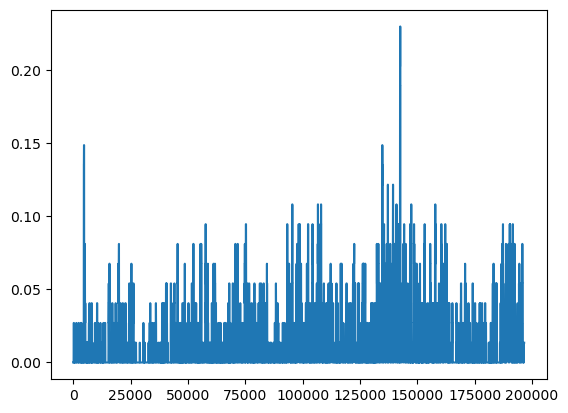

In [33]:
#and with that, we have our final data
import matplotlib.pyplot as plt
plt.plot(seq[0])

In [ ]:
seq.max() #not even affected by the crop lmfao!!

5.305

In [37]:
#wait there's 2 more steps, first it's extreme clipping
extreme_clip = np.percentile(seq, 100*0.9999, axis=1)
#now applyy it to the seq along the axis again
seq = np.minimum(seq, extreme_clip[:,None])

In [38]:
#and the final step is if it's unmappable, we deal with it
unmap = np.load("/data1/lesliec/sarthak/data/borzoi/umap.npz")
unmap = unmap[chrom][start:end]
print(unmap.sum())

69338


In [43]:
unmap.shape

(196608,)

In [40]:
seq_target_null = np.percentile(seq, q=[100*0.5], axis=1)
seq_target_null.shape

(1, 674)

In [45]:
seq[:,unmap==1].shape

(674, 69338)

In [ ]:
# (seq[:,unmap==1] == seq[:,unmap[0]==1]).all() #this is true, so we can just do this
#this is not true, so don't do unmap [0], just as is, otherwise broadacasts elementwise, remember that's dumb!!

ValueError: operands could not be broadcast together with shapes (674,69338) (674,1,196608) 

In [ ]:
seq_target_null[:,None].shape

(1, 1, 674)

In [ ]:
seq_target_null[0,:,None].shape #this is correct

(674, 1)

In [49]:
#and now applyy the unmap
# seq[:,unmap==1] = seq_target_null[:,None]
seq_unmap = seq[:,unmap==1]
seq_unmap = np.minimum(seq_unmap, seq_target_null[0,:,None])
seq[:,unmap==1] = seq_unmap

In [52]:
seq_target_null.max()

0.0643310546875

In [50]:
seq.max() #this is 128, so it's working

5.291783203124851

In [ ]:
baseline_cov[:,None].shape #yeah it's correct

(674, 1)

In [ ]:
#let's do it all at once

#load the sequence
seq = zarr_open[chrom][:,start:end]

#load the blacklist and define values to set it to
blacklist = loaded[chrom][start:end]
if blacklist.sum() > 0:
    baseline_cov = np.percentile(seq, 100*0.5, axis=1)
    seq_blacklist = seq[:,blacklist==1]
    seq_blacklist = np.minimum(seq_blacklist, baseline_cov[:,None])
    seq[:,blacklist==1] = seq_blacklist

#technically pooling is done here, but it's ok we can do it later, doesn't change the clipping since it's all mean? might change the percentile stuff for unmappable clipping tho

#scale and clip soft then clip
seq = seq*2
clip_mask = (seq > 32)
seq[clip_mask] = np.sqrt(seq[clip_mask] - 32+1) + 31
seq = np.clip(seq,0,128)

#extreme clip
extreme_clip = np.percentile(seq, 100*0.9999, axis=1)
seq = np.minimum(seq, extreme_clip[:,None])


#load unmappable regions and find the percentile to set values to
unmap = np.load("/data1/lesliec/sarthak/data/borzoi/umap.npz")
unmap = unmap[chrom][start:end]
seq_target_null = np.percentile(seq, q=[100*0.5], axis=1)
seq_unmap = seq[:,unmap==1]
seq_unmap = np.minimum(seq_unmap, seq_target_null[0,:,None])
seq[:,unmap==1] = seq_unmap
seq.max()

#it's certainly ynot the fastest, 9 seconds to load the data and process...

5.291783203124851

In [ ]:
seq.dtype

dtype('float64')

# let's benchmark the speed quickly and see what's slow or fast

In [60]:
zarr_open = zarr.open("/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/test_chrom_dnase_chunkchrom.zarr", mode='r')

In [65]:
chrom = 'chr13'
start = 18604798
end = 18801406

In [66]:
# now let's test it

def process_data(seq, blacklist, unmap, scale, clip, clip_soft, blacklist_pct=0.5, umap_clip=0.5):
    '''This function will process the data, it does the basenji processing where you do blacklist clipping
    Then skip pooling (can do it later, only might affect unmappable clipping, but if doing mean pooling won't affect clipsoft and clip),
    Then scale and clip soft then clip, 
    then extereme clip,
    then change unmappable regions
    
    Args:
        seq: the sequence to process
        blacklist: the already loaded values form the blacklist npz file that was loaded
        unmappable_npz: the already loaded values from the unmappable regions npz file that was loaded
        scale: the scale to apply (from targets.txt)
        clip: the clip to apply (from targets.txt)
        clip_soft: the soft clip to apply (from targets.txt)
        blacklist_pct: the percentage to clip the blacklist to
        
    
    '''
    #first find blacklist values and if they overlap, clip them to baseline
    if blacklist.sum() > 0:
        baseline_cov = np.percentile(seq, 100*blacklist_pct, axis=1)
        seq_blacklist = seq[:,blacklist==1]
        seq_blacklist = np.minimum(seq_blacklist, baseline_cov[:,None])
        seq[:,blacklist==1] = seq_blacklist
    
    #now scale and clip soft then clip
    seq = seq * scale
    clip_mask = (seq > 32)
    seq[clip_mask] = np.sqrt(seq[clip_mask] - clip_soft+1) + clip_soft-1
    seq = np.clip(seq,0,clip)
    
    #now extreme clip
    extreme_clip = np.percentile(seq, 100*0.9999, axis=1)
    seq = np.minimum(seq, extreme_clip[:,None])

    #and finally, use unmappable regions
    seq_target_null = np.percentile(seq, q=[100*umap_clip], axis=1)
    seq_unmap = seq[:,unmap==1]
    seq_unmap = np.minimum(seq_unmap, seq_target_null[0,:,None])
    seq[:,unmap==1] = seq_unmap

    return seq

import time
start_time = time.time()
seq = zarr_open[chrom][:,start:end]
print('load seq:',time.time()-start_time)

start_time = time.time()
seq = process_data(seq, blacklist, unmap, 2, 128, 32)
print('process seq:',time.time()-start_time)

load seq: 2.811349630355835
process seq: 6.277900695800781


In [ ]:
#let's see what happens if we don't do blacklist
def process_data(seq, blacklist, unmap, scale, clip, clip_soft, blacklist_pct=0.5, umap_clip=0.5):
    '''This function will process the data, it does the basenji processing where you do blacklist clipping
    Then skip pooling (can do it later, only might affect unmappable clipping, but if doing mean pooling won't affect clipsoft and clip),
    Then scale and clip soft then clip, 
    then extereme clip,
    then change unmappable regions
    
    Args:
        seq: the sequence to process
        blacklist: the already loaded values form the blacklist npz file that was loaded
        unmappable_npz: the already loaded values from the unmappable regions npz file that was loaded
        scale: the scale to apply (from targets.txt)
        clip: the clip to apply (from targets.txt)
        clip_soft: the soft clip to apply (from targets.txt)
        blacklist_pct: the percentage to clip the blacklist to
        
    
    '''
    #first find blacklist values and if they overlap, clip them to baseline
    start = time.time()
    if blacklist.sum() > 0:
        baseline_cov = np.percentile(seq, 100*blacklist_pct, axis=1)
        seq_blacklist = seq[:,blacklist==1]
        seq_blacklist = np.minimum(seq_blacklist, baseline_cov[:,None])
        seq[:,blacklist==1] = seq_blacklist
    print('blacklist:',time.time()-start)

    #now scale and clip soft then clip
    start = time.time()
    seq = seq * scale
    clip_mask = (seq > 32)
    seq[clip_mask] = np.sqrt(seq[clip_mask] - clip_soft+1) + clip_soft-1
    seq = np.clip(seq,0,clip)
    
    #now extreme clip
    extreme_clip = np.percentile(seq, 100*0.9999, axis=1)
    seq = np.minimum(seq, extreme_clip[:,None])
    print('clip:',time.time()-start)

    #and finally, use unmappable regions
    start = time.time()
    seq_target_null = np.percentile(seq, q=[100*umap_clip], axis=1)
    seq_unmap = seq[:,unmap==1]
    seq_unmap = np.minimum(seq_unmap, seq_target_null[0,:,None])
    seq[:,unmap==1] = seq_unmap
    print('unmap:',time.time()-start)

    return seq

seq = zarr_open[chrom][:,start:end]
seq = process_data(seq, blacklist, unmap, 2, 128, 32)

#9 seconds overall

blacklist: 0.8846228122711182
clip: 3.3365132808685303
unmap: 2.036334991455078


In [ ]:
#let's check stuff to see what can speed it up



seq = zarr_open[chrom][:,start:end]
clip_mask = seq > 32
# seq = process_data(seq, blacklist, unmap, 2, 128, 32)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [ ]:
clip_mask.sum()

0

In [74]:
unmap.sum()

69338

In [75]:
#so we can edit it to check if there's anythign in the clip mask
def process_data(seq, blacklist, unmap, scale, clip, clip_soft, blacklist_pct=0.5, umap_clip=0.5):
    '''This function will process the data, it does the basenji processing where you do blacklist clipping
    Then skip pooling (can do it later, only might affect unmappable clipping, but if doing mean pooling won't affect clipsoft and clip),
    Then scale and clip soft then clip, 
    then extereme clip,
    then change unmappable regions
    
    Args:
        seq: the sequence to process
        blacklist: the already loaded values form the blacklist npz file that was loaded
        unmappable_npz: the already loaded values from the unmappable regions npz file that was loaded
        scale: the scale to apply (from targets.txt)
        clip: the clip to apply (from targets.txt)
        clip_soft: the soft clip to apply (from targets.txt)
        blacklist_pct: the percentage to clip the blacklist to
        
    
    '''
    #first find blacklist values and if they overlap, clip them to baseline
    start = time.time()
    if blacklist.sum() > 0:
        baseline_cov = np.percentile(seq, 100*blacklist_pct, axis=1)
        seq_blacklist = seq[:,blacklist==1]
        seq_blacklist = np.minimum(seq_blacklist, baseline_cov[:,None])
        seq[:,blacklist==1] = seq_blacklist
    print('blacklist:',time.time()-start)

    #now scale and clip soft then clip
    start = time.time()
    seq = seq * scale
    clip_mask = (seq > 32)
    if clip_mask.sum() > 0:
        seq[clip_mask] = np.sqrt(seq[clip_mask] - clip_soft+1) + clip_soft-1
        seq = np.clip(seq,0,clip)

        #now extreme clip
        extreme_clip = np.percentile(seq, 100*0.9999, axis=1)
        seq = np.minimum(seq, extreme_clip[:,None])
    print('clip:',time.time()-start)

    #and finally, use unmappable regions
    start = time.time()
    if unmap.sum() > 0:
        seq_target_null = np.percentile(seq, q=[100*umap_clip], axis=1)
        seq_unmap = seq[:,unmap==1]
        seq_unmap = np.minimum(seq_unmap, seq_target_null[0,:,None])
        seq[:,unmap==1] = seq_unmap
    print('unmap:',time.time()-start)

    return seq

seq = zarr_open[chrom][:,start:end]
seq = process_data(seq, blacklist, unmap, 2, 128, 32)

blacklist: 0.8817660808563232
clip: 1.1256473064422607
unmap: 1.576805830001831


# final steps

Now we have a way to process the data, find a good wayy to finalize and make this dataset class!! Not too hard, just has to do things like

Loop ovewr sequences file or span the genome, so arguments about span and length

If outside of a certain region in the span, can 'clean up' the data and remove those values when reporting the final length 

Mayybe just quickly goes through and makes a quick sequences.txt file! or a df or whatever

Then we also have to make sure to add lengths to the left and right if outside of the genome (also add values to the blacklist and unmappables!)

that should do it for now, see other datasets, mainly graph reg and GPN one to see if we missing anything! Make it good

One thing we can do is if we want a subset and say create it, it will create it and then test it!

First let's test it and see speed, see if it's the slowdown, or if it's fine as is... we can always just make a function to create subset of the data

# created the dataset, now we test it

Then we will also look at some threshold stuff, like how to set it

In [76]:
from src.dataloaders.datasets.general_dataset import GeneralDataset

dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288
)

In [77]:
#now we can test things
#I timed it already, but basicallyy it takes 2 minutes to load in the full dataset,s so not an issue at all
#but let's find a region that is close to the thing, the main seqs is 131k, and we move more than 131k to the left
#let's find an example that is at the start of the chromosome to see how it deals with extensions
seqs = dataset.sequences
seqs

,0,1,2,3
0,chr18,928386,1059458,train
1,chr4,113630947,113762019,train
2,chr11,18427720,18558792,train
3,chr16,85805681,85936753,train
4,chr3,158386188,158517260,train
...,...,...,...,...
34016,chr7,50515122,50646194,train
34017,chr7,135602769,135733841,train
34018,chr4,189004198,189135270,train
34019,chr4,10438099,10569171,train


In [78]:
#find an example in the pd array that is a value less than 131k
seqs[seqs[1] < 131000] #this is the first one, so let's use this

,0,1,2,3
1022,chr3,10000,141072,train
1400,chr10,75599,206671,train
6733,chr4,75599,206671,train
17051,chr6,125599,256671,train
18309,chr16,75599,206671,train
19543,chr3,75599,206671,train
21324,chr17,125599,256671,train
25870,chr4,10000,141072,train
27331,chr5,10000,141072,train
27661,chr12,75599,206671,train


In [79]:
#let's do chr3 from 10000 to 141072
chrom = 'chr3'
start = 10000
end = 141072
seq = dataset.data[chrom][:,start:end]
seq.shape

(1, 131072)

In [80]:
seq

array([[0.        , 0.        , 0.        , ..., 0.05328369, 0.05328369,
        0.05328369]])

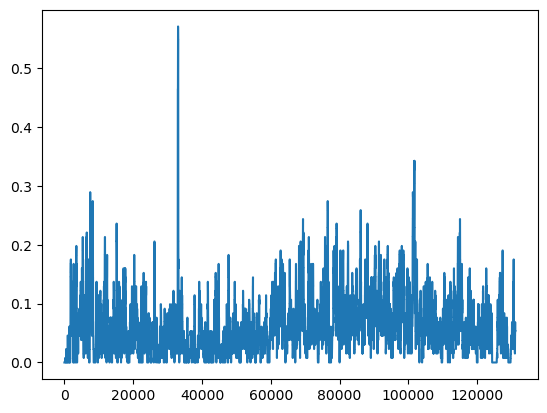

In [82]:
plt.plot(seq[0])

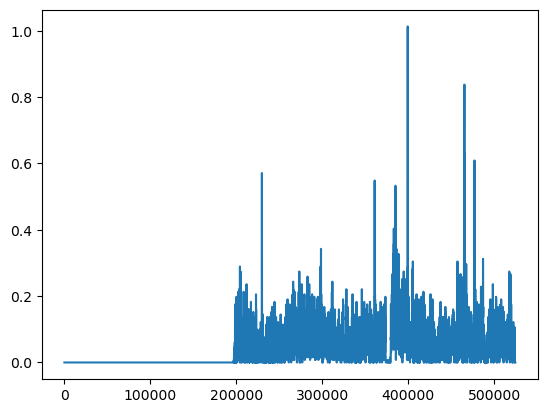

In [ ]:
data,label = dataset[1022]
plt.plot(label[0]) #this is the label, so it's the same as the seq, but with the extension
#this is definitely extended, if we plot ours in the middle it's a perfect match

In [88]:
label.shape

torch.Size([1, 524288])

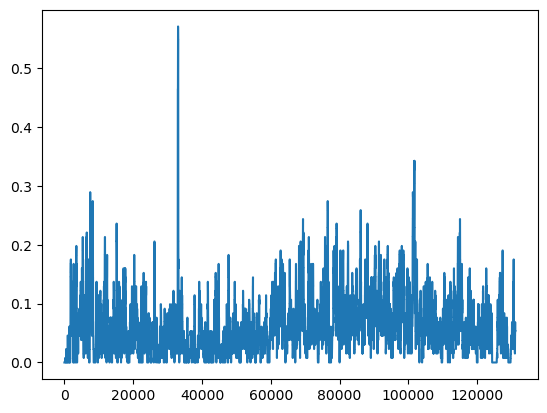

In [90]:
#let's verify it's the case
#let's get the middle 131072 of the label
middle = label.shape[1]//2
middle_start = middle - 131072//2
middle_end = middle + 131072//2
plt.plot(label[0,middle_start:middle_end]) #this is the label, so it's the same as the seq, but with the extension

In [ ]:
np.allclose(label[0,middle_start:middle_end], seq[0]) #this is true, so it's the same, meaning it is indeed correct

True

In [92]:
#now let's check the actual sequence too
seq = dataset.genome[chrom][start:end]
print(seq.shape)
seq

(131072,)


array([ 8, 10,  7, ...,  7,  7, 10], dtype=int8)

In [93]:
data.shape

torch.Size([4, 524288])

In [94]:
data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [ ]:
#let's find the overlap again
data[:,middle_start:middle_end] #clearly looks correct

tensor([[0., 0., 1.,  ..., 1., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.]])

In [96]:
#let's check like the first 12 or so

data[:,middle_start:middle_end][:, :12] #this is the first 12, so it's correct

tensor([[0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [97]:
seq[:12]

array([ 8, 10,  7,  7,  8,  8,  8, 10,  7,  7,  8,  8], dtype=int8)

In [99]:
#yyeah I think it's fine, the one thing is we will have a separate class for N

#changed it, but let's test to make sure our shapes are right

data = dataset.data[chrom][:,1000000:1000010]
data

array([[0.06854248, 0.06854248, 0.06854248, 0.06854248, 0.06854248,
        0.07611084, 0.07611084, 0.07611084, 0.07611084, 0.07611084]])

In [ ]:
import torch
torch.tensor(data).flip(0) #this doesn't do anyything!

tensor([[0.0685, 0.0685, 0.0685, 0.0685, 0.0685, 0.0761, 0.0761, 0.0761, 0.0761,
         0.0761]], dtype=torch.float64)

In [ ]:
torch.tensor(data).transpose(0,1).flip(0) #actually reverses things now!

tensor([[0.0761],
        [0.0761],
        [0.0761],
        [0.0761],
        [0.0761],
        [0.0685],
        [0.0685],
        [0.0685],
        [0.0685],
        [0.0685]], dtype=torch.float64)

In [ ]:
#so I changed the shapes too, now we can restart the server and see what the shapes are like and if this makes sense!
#we will also test the pool feature, can see if it works as we expect!!

import numpy as np
import torch
from src.dataloaders.datasets.general_dataset import GeneralDataset

dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    pool=128
)

In [2]:
out = dataset[0]

In [3]:
out[0].shape

torch.Size([5, 524288])

In [4]:
out[1].shape

torch.Size([4096, 1])

In [ ]:
524288/128 #the output shape cuz we did the pooling, makes sense!

4096.0

In [6]:
#let's also do rc augmentation
dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    pool=128,
    rc_aug=True,
)
out = dataset[0]
print(dataset.last_flip)

False


In [ ]:
#so in this case it did not flip the last element, let's redo it
data,label = dataset[1022]
print(dataset.last_flip) 

IndexError: arrays used as indices must be of integer (or boolean) type

In [8]:
dataset.length

524288

In [ ]:
#huh why is it going into the thing, it's going into the else statement that should only happen when self.length is none, but it clealry isn't?
#also why is it giving this error anyways, that's weird
chrom, start, end, split = dataset.sequences.iloc[1022]
print(chrom, start, end, split) #yeah this is what we've been using for forever

chr3 10000 141072 train


In [ ]:
dataset.genome[chrom][start:end] #so it works if you call it directly, I think the issue is that it goes both the if and else?
#let's reload it and see if it's still an issue, this is strange!

array([ 8, 10,  7, ...,  7,  7, 10], dtype=int8)

In [ ]:
import numpy as np
import torch
from src.dataloaders.datasets.general_dataset import GeneralDataset

dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    pool=128,
    rc_aug=True,
)
out = dataset[1022]
print(dataset.last_flip)

#ok mismatch was what was imported was different, so pointed to the wrong line!! that's why don't edit after make it

doing cropping


IndexError: arrays used as indices must be of integer (or boolean) type

In [3]:
chrom, start, end, split = dataset.sequences.iloc[1022]
seq = dataset.genome[chrom][start:end]
dataset.complement_array

array([ 0,  0,  0,  0,  0,  0,  0, 10,  9,  8,  7, 11])

In [4]:
seq

array([ 8, 10,  7, ...,  7,  7, 10], dtype=int8)

In [ ]:
dataset.complement_array[seq]

array([ 9,  7, 10, ..., 10, 10,  7])

In [ ]:
dataset.complement_array[seq[::-1]] #so this works, the issue is with padding somehow it runs into an issue, let's manually pad

array([ 7, 10, 10, ..., 10,  7,  9])

In [7]:
leftpad = np.zeros(0)
rightpad = np.zeros(0)
if dataset.length is not None:
    diff = dataset.length - (end - start)
    if diff > 0:
        start = start - diff // 2
        end = end + diff // 2
        print(diff, start, end)
        if start < 0:
            leftpad = np.ones(-start)*11
            start = 0
        chromlen = dataset.genome[chrom].shape[0]
        if end > chromlen:
            rightpad = np.ones(end-chromlen)*11
            end = chromlen
        seq = np.concatenate([leftpad, dataset.genome[chrom][start:end], rightpad])

393216 -186608 337680


In [ ]:
seq.dtype #yeah so that's the issue, the left and rightpad are float64, we can make it int8 I guess?

dtype('float64')

In [ ]:
np.zeros(0).dtype #yeah that's the default, now this makes sense!

dtype('float64')

In [1]:
#now restart and do it again!

import numpy as np
import torch
from src.dataloaders.datasets.general_dataset import GeneralDataset

dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
    pool=128,
    rc_aug=True,
)
out = dataset[1022]
print(dataset.last_flip)

True


In [9]:
out[0].shape, out[1].shape #this is correct, so now we can check the rc augmentation

(torch.Size([5, 524288]), torch.Size([4096, 1]))

In [2]:
#now let's verify this is actually the reverse complement and what we would expect
start = -186608
end = 337680
chrom = 'chr13'
seq = dataset.genome[chrom][0:end]
print(seq.shape)

(337680,)


In [ ]:
#note that we will have a ton of values that are 11 that are now at the end cuz it's flipped
#let's verify all those values are 11
out[0][:,start:].sum(1) #all just Ns

tensor([     0.,      0.,      0.,      0., 186608.])

In [ ]:
out[0][:,start-300000:].sum(1) #all just Ns

tensor([ 91326.,  55809.,  54405.,  88460., 196608.])

In [ ]:
#now turn the one hot into a vector of the index


tensor([     0,      5,      1,      7, 327680])

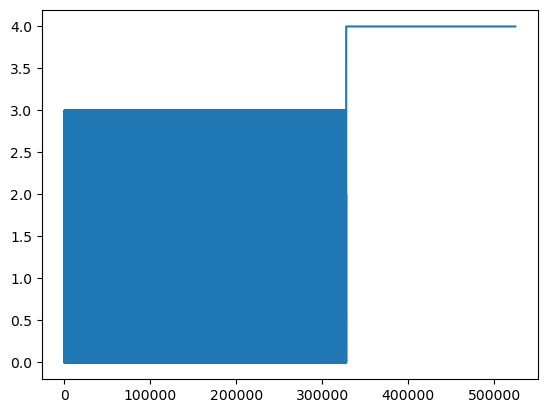

In [ ]:
collapsed = np.argmax(out[0], axis=0)
import matplotlib.pyplot as plt
plt.plot(collapsed) #yeah all the end values are as expected, simply just Ns!!!!

In [11]:
#now let's look at some of the values
seq_reversed = seq[::-1]
seq_reversed[:100]

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype=int8)

In [ ]:
np.unique(seq) #wait wtf, somethis is wrong

array([11], dtype=int8)

In [19]:
seq.shape

(337680,)

In [ ]:
# dataset.genome['chr13'][:337680] #this is the original sequence, so it should have lots of unique values
np.unique(dataset.genome['chr13'][:3337680]) #why is there N values all the way until 3.3 million?? if go to 30 million then you see some real values, this is strange when data clealry not like that

array([11], dtype=int8)

In [ ]:
chrom, start, end, split = dataset.sequences.iloc[1022]
print(chrom, start, end, split) #this is the one we are using
#oh we're using th ewrong chromosome lmfaoooo

chr3 10000 141072 train


In [26]:
start = -186608
end = 337680
seq = dataset.genome['chr3'][0:end]
seq_reversed = seq[::-1]

In [27]:
seq_reversed[:100]

array([10,  8,  8,  8, 10,  9, 10,  7,  8,  8,  7,  7,  8, 10, 10,  8,  9,
        7,  8, 10, 10, 10, 10,  9,  9, 10,  7,  9, 10,  7,  7, 10,  7,  9,
       10,  8,  9, 10, 10, 10,  7,  7, 10,  7,  9,  8,  9, 10, 10,  8,  8,
       10,  9, 10, 10, 10, 10, 10, 10,  9,  9, 10, 10, 10,  9, 10,  7,  7,
        8,  9, 10,  7,  8,  7,  7,  9,  7,  9, 10,  9,  7,  9, 10,  7, 10,
       10,  8,  7,  8,  8,  8, 10, 10,  7,  7,  8, 10, 10,  9, 10],
      dtype=int8)

In [ ]:
collapsed[:100]+7

tensor([ 7,  9,  9,  9,  7,  8,  7, 10,  9,  9, 10, 10,  9,  7,  7,  9,  8, 10,
         9,  7,  7,  7,  7,  8,  8,  7, 10,  8,  7, 10, 10,  7, 10,  8,  7,  9,
         8,  7,  7,  7, 10, 10,  7, 10,  8,  9,  8,  7,  7,  9,  9,  7,  8,  7,
         7,  7,  7,  7,  7,  8,  8,  7,  7,  7,  8,  7, 10, 10,  9,  8,  7, 10,
         9, 10, 10,  8, 10,  8,  7,  8, 10,  8,  7, 10,  7,  7,  9, 10,  9,  9,
         9,  7,  7, 10, 10,  9,  7,  7,  8,  7])

In [33]:
#we can clealry see it's the ocmplement, so after reversed, all the complement stuff!!
complements = {7:10, 8:9, 9:8, 10:7, 11:11}
for i,s in enumerate(seq_reversed):
    if complements[s] != collapsed[i]+7:
        print(i, s, collapsed[i])
        break

In [34]:
#RC obviously works, now let's test the pooling

#we still have the output, let's reverse it and then compare
out[1].shape

torch.Size([4096, 1])

In [37]:
data = dataset.data[chrom][:,0:end]
data.shape

(1, 337680)

In [38]:
data = data[0]
tdata = out[1][:,0]
print(data.shape, tdata.shape)

(337680,) torch.Size([4096])


In [39]:
#now let's compare the values
data_rev = data[::-1]
data_rev[:128].mean()

0.0

In [40]:
tdata[0]

tensor(0.)

In [ ]:
tdata[:100] #starting from value 3

tensor([0.0000, 0.0000, 0.0000, 0.0102, 0.0285, 0.0459, 0.0785, 0.0381, 0.0745,
        0.0599, 0.0455, 0.0575, 0.0749, 0.0382, 0.0280, 0.0302, 0.0655, 0.0846,
        0.0939, 0.0572, 0.0494, 0.0271, 0.0177, 0.0212, 0.0146, 0.0463, 0.0275,
        0.0000, 0.0000, 0.0324, 0.0372, 0.0435, 0.0211, 0.0401, 0.0849, 0.0337,
        0.0466, 0.1297, 0.0964, 0.0720, 0.0996, 0.0721, 0.0763, 0.1380, 0.1773,
        0.0247, 0.0625, 0.0951, 0.0235, 0.0160, 0.0451, 0.1106, 0.1900, 0.1976,
        0.2323, 0.1199, 0.0707, 0.0597, 0.1011, 0.0909, 0.1084, 0.1199, 0.0471,
        0.0666, 0.0818, 0.1048, 0.1054, 0.1202, 0.1249, 0.1123, 0.1041, 0.0447,
        0.0505, 0.0656, 0.1027, 0.0241, 0.0249, 0.0187, 0.0090, 0.0261, 0.0370,
        0.0509, 0.0463, 0.0530, 0.0716, 0.0600, 0.0962, 0.0681, 0.0855, 0.0735,
        0.0583, 0.0322, 0.0461, 0.0870, 0.0563, 0.0220, 0.0204, 0.0364, 0.0487,
        0.0941])

In [43]:
s = 128*3
data_rev[s:s+128].mean() #this is the mean of the pooled values, so it should be the same as the target

0.010172009468078613

In [ ]:
#let's check the next one
s = 128*4
data_rev[s:s+128].mean() #this is indeed correct. LEt's finalize it by checking some of th elast values

0.028488755226135254

In [45]:
tdata[-100:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [ ]:
#all zeros
data_rev[-98*128:].mean() #this should also be zero, why isn't it?

0.008183289547355808

In [49]:
#oh because we have all the appended values! This makes it hard, we can make a true one where we append a bunch of zeros
data_rev.shape

(337680,)

In [50]:
true_data = np.zeros(524288)
true_data[:data_rev.shape[0]] = data_rev
true_data[-100*128:].mean() #this is indeed zero, so now we can check the last values

0.0

In [ ]:
#find the last element of tdata that is not zero
last_nonzero = np.where(tdata != 0)[0][-1]
last_nonzero #this is it

2558

In [53]:
tdata[2558]

tensor(0.0042)

In [55]:
#now check the true data
s = 2558
true_data[s*128:(s+1)*128].mean() #this is indeed correct, so we can see that the pooling works as expected

0.004223465919494629

In [ ]:
#works like a charm!! jkust check some last values
s = 128*4
true_data[s:s+128].mean() #perfeclty fine!!!!

0.028488755226135254

In [57]:
out = dataset[1022]
print(out[0].shape, out[0].dtype)
print(out[1].shape, out[1].dtype)

torch.Size([5, 524288]) torch.float32
torch.Size([4096, 1]) torch.float32


In [ ]:
out[0] #5 is N, this is good!

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

# so it works, we can confirm this approach makes sense!

Now difficult part is deciding how to mask and combine the data

In [62]:
#we worked on and made this function, we need to test it

def mask_data(seq, mask_pct=0.15):
    """This function will mask the data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, 5) if one hot encoding
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, 6) if one hot encoding, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, 6), where the last column is the mask track (tells all elements that have been changed)
    """
    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((seq.shape[0],), mask_pct) #size of length, defines for each element if we mask it or not
    masked_indices = torch.bernoulli(probability_matrix).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6],
    # where the last column is the mask track
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    random_tokens = torch.randint(0, 4, (random_positions.numel(),))
    random_one_hot = torch.zeros((random_positions.numel(), 4))
    random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
    seq_masked[random_positions, :4] = random_one_hot
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing

test_seq = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1],[0,0,0,0,1]] #ACGTNN
test_seq = torch.tensor(test_seq, dtype=torch.float32)
print(test_seq.shape)



torch.Size([6, 5])


In [64]:
#should be shape length x 5 which it is, so we can input it
masked_seq, unmasked_seq = mask_data(test_seq, mask_pct=0.5)
print(masked_seq.shape) #should be length x 6, so 5 for the one hot and 1 for the mask track

IndexError: too many indices for tensor of dimension 0

In [65]:
#hmmmm, seems we have some issues, let's manually go through and test it
seq = test_seq.clone()
mask_pct = 0.5
probability_matrix = torch.full((seq.shape[0],), mask_pct)
masked_indices = torch.bernoulli(probability_matrix).bool()
print(probability_matrix)

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000])


In [ ]:
print(masked_indices) #yeah this is exactly what we'd exxpect

tensor([ True,  True, False, False,  True,  True])


In [67]:
all_mask_positions = torch.nonzero(masked_indices).squeeze()
num_masked = all_mask_positions.numel()
print(all_mask_positions)
print(num_masked) #this is the number of masked positions, so we can see how many we have

tensor([0, 1, 4, 5])
4


In [ ]:
num_mask = int(0.8 * num_masked)
num_random = int(0.1 * num_masked)
permuted = all_mask_positions[torch.randperm(num_masked)]
print(permuted)
mask_positions = permuted[:num_mask]  # 80%: replace with mask token
random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is
print(mask_positions,random_positions, unchanged_positions) #these are the positions we will mask, random and unchanged

#ahh see the issue is our sequence is so short that it may be what is causing the issue!

tensor([1, 4, 0, 5])
tensor([1, 4, 0]) tensor([], dtype=torch.int64) tensor([5])


In [70]:
#let' smake our test seq longer
conversion = {'A': (1,0,0,0,0), 'C': (0,1,0,0,0), 'G': (0,0,1,0,0), 'T': (0,0,0,1,0), 'N': (0,0,0,0,1)}

test_seq = 'ACGTNAAAAACCCCCCTCTCTCTGGGGGGGGGGGGNNNNNNNNNNNNNNNACTNTNTNTNNNNNNNNNNNNNNNNNNNNN'
test_seq = [conversion[i] for i in test_seq]
# print(test_seq)
test_seq = torch.tensor(test_seq, dtype=torch.float32)
print(test_seq)
print(test_seq.shape) #should be shape length x 5 which it is, so we can input it

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0

In [72]:
#now let's input this into it
masked_seq, unmasked_seq = mask_data(test_seq, mask_pct=0.5)
print(masked_seq)

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0

In [73]:
print(unmasked_seq) #should be length x 6, so 5 for the one hot and 1 for the mask track

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0

In [74]:
#so let's verify it works
torch.allclose(unmasked_seq[:,:-1], test_seq) #this should be true, so we can see that the unmasked sequence is indeed the same as the original sequence

True

In [ ]:
#so we have the same values, but it also specifies which values are masked, let's see the percentage
masked_seq[:,-1].sum() #roughly half, this is right!! 

tensor(32.)

In [ ]:
#wait masked seq has some major issues, for some reason it can sometimes have 2 values... it should never be 2 values
masked_seq.sum(1) #it's masked, should only be 1 thing!!

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 2., 1., 1.])

In [80]:
#issue is that it doesn't replace it with the proper one, rather it seems to add a second value... let's check this
random_positions = torch.tensor([10,3]) #let's just say this
random_tokens = torch.randint(0, 4, (random_positions.numel(),))
random_one_hot = torch.zeros((random_positions.numel(), 4))
print(random_tokens, random_one_hot)

tensor([1, 2]) tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])


In [81]:
random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)

tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.]])

In [ ]:
#right this seems correct...
torch.randint(0,4,(100,)) #between 0 and 3 as we expect!

tensor([3, 1, 2, 3, 3, 2, 2, 2, 3, 3, 1, 3, 2, 1, 1, 2, 3, 0, 0, 1, 0, 2, 0, 2,
        3, 0, 1, 3, 2, 2, 1, 2, 1, 3, 1, 0, 2, 0, 0, 0, 3, 1, 3, 1, 1, 1, 0, 3,
        3, 3, 3, 3, 0, 0, 1, 2, 0, 2, 1, 3, 0, 3, 2, 2, 3, 3, 2, 1, 0, 0, 0, 3,
        0, 0, 2, 3, 1, 0, 0, 3, 3, 3, 0, 1, 3, 3, 0, 0, 2, 1, 0, 0, 1, 0, 0, 2,
        1, 3, 1, 3])

In [84]:
#oh the issue is if it was originally N and we need to replace it by random, the N remains, we dont' want to generate N, but it can still have that, so need to manually set it to 0!
#it's as simple as adding a line saying that set the N to 0 before we add in the replacement.

#or do something like this

def mask_data(seq, mask_pct=0.15):
    """This function will mask the data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, 5) if one hot encoding
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, 6) if one hot encoding, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, 6), where the last column is the mask track (tells all elements that have been changed)
    """
    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((seq.shape[0],), mask_pct) #size of length, defines for each element if we mask it or not
    masked_indices = torch.bernoulli(probability_matrix).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6],
    # where the last column is the mask track
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    random_tokens = torch.randint(0, 4, (random_positions.numel(),))
    random_one_hot = torch.zeros((random_positions.numel(), 5))
    random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
    seq_masked[random_positions, :5] = random_one_hot
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing

#now let's test it again, use the old test seq
masked_seq, unmasked_seq = mask_data(test_seq, mask_pct=0.5)
print(masked_seq)

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0

In [85]:
print(unmasked_seq) #should be length x 6, so 5 for the one hot and 1 for the mask track

tensor([[1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0

In [ ]:
masked_seq.sum(1) #nothing is greater than 1, this is good! Let's test a few more things

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.])

In [87]:
test_seq = 'ACTCTCTCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGTGTGTAGGGTTTTGGGCCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'*10
test_seq = [conversion[i] for i in test_seq]
test_seq = torch.tensor(test_seq, dtype=torch.float32)
print(test_seq.shape) #should be shape length x 5 which it is, so we can input it

torch.Size([1790, 5])


In [88]:
#now let's input this into it
masked_seq, unmasked_seq = mask_data(test_seq, mask_pct=0.5)
print(masked_seq)

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])


In [89]:
print(unmasked_seq) #should be length x 6, so 5 for the one hot and 1 for the mask track

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.]])


In [ ]:
masked_seq.sum(1).max() #good, it does indeed replace the N values as well

tensor(1.)

In [92]:
#now let's input this with an actual sequence and see what's up
seq,data = dataset[1022]
seq.shape

torch.Size([5, 524288])

In [ ]:
masked_seq, unmasked_seq = mask_data(seq.transpose(1,0), mask_pct=0.5)
print(masked_seq.shape) #should be length x 6, so 5 for the one hot and 1 for the mask track
masked_seq.sum(1).max() #good, it does indeed have a 1 mask and is incredibly fast!

torch.Size([524288, 6])


tensor(1.)

In [ ]:
for i in range(100):
    seq,data = dataset[1022]
    masked_seq, unmasked_seq = mask_data(seq.transpose(1,0), mask_pct=0.5)
    print(masked_seq.shape) #should be length x 6, so 5 for the one hot and 1 for the mask track
    masked_seq.sum(1).max() #good, it does indeed have a 1 mask and is incredibly fast!
#3 seconds, and I think the slow part is the computing the max lol

torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([524288, 6])
torch.Size([5242

In [ ]:
for i in range(100):
    seq,data = dataset[1022]
    masked_seq, unmasked_seq = mask_data(seq.transpose(1,0), mask_pct=0.5)
#ok the max was fast, but still it's 2.5 seconds to run it 100 times, so this is incredibly fast and not at all the slowdown!!!

In [97]:
#let's look at a random sequence
print(seq.shape)
print(masked_seq.shape)
print(unmasked_seq.shape)

torch.Size([5, 524288])
torch.Size([524288, 6])
torch.Size([524288, 6])


In [ ]:
print(masked_seq[10000:10010]) #shows you what is masked, and a lot of masked elements and Ns since it's literally 1254

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.]])


In [ ]:
seq.transpose(1,0)[10000:10010] #yes it is all Ns

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])

In [ ]:
#and unmasked should show all Ns but also tell us what is masked
unmasked_seq[10000:10010] #works exactly as expected!!

tensor([[0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 0.]])

In [ ]:
#let's look at another region
seq.transpose(1,0)[int(5e5):int(5e5)+10]

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])

In [ ]:
masked_seq[int(5e5):int(5e5)+10]

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.]])

In [105]:
unmasked_seq[int(5e5):int(5e5)+10] #this is all masked, so it works as expected

tensor([[1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1.]])

In [107]:
#let's find a region that was replaced at random!
start = int(5e5)+5000
end = start+10
masked_seq[start:end]

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])

In [ ]:
unmasked_seq[start:end] #here the first value was changed to something random but the model doesn't know

tensor([[0., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1.]])

In [ ]:
seq.transpose(1,0)[start:end] #this is the original sequence, matches the unmasked, I'd say it looks good!!

tensor([[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [110]:
#final thing is rerun it and make sure the numbers add up
masked_seq, unmasked_seq = mask_data(seq.transpose(1,0), mask_pct=0.15)
print(masked_seq.sum(0))

tensor([ 88853.,  54288.,  56099.,  91999., 169865.,  63184.])


In [ ]:
#we get like 63000, wait but that excludes the 20% of the masked things that are idfferent
print(unmasked_seq.sum(0)[-1])
#this looks like, roughtly 80k is 15% of the 500k, so we're good

tensor(78981.)


# testing masking accessibility

In [ ]:
#still working on the function, let's just paste and define things here
span = 2
seq = torch.arange(100)
mask_pct = 0.5

num_elements = seq.shape[0]//span #chunks into chunks of size span
    
if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
    seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things

# Create a probability vector (one per token) and sample which tokens to mask
probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
masked_indices = torch.bernoulli(probability_matrix).bool() #finds which indices to mask, so shape is length, and is True or False for each index

print('seq shape:', seq.shape)
print(probability_matrix)
print(masked_indices) #so far no issues at all

seq shape: torch.Size([100, 1])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000])
tensor([ True, False, False, False,  True,  True,  True, False, False,  True,
         True,  True, False,  True, False,  True,  True,  True, False, False,
        False, False, False, False,  True, False, False,  True,  True,  True,
         True,  True, False,  True,  True,  True, False, False,  True, False,
         True, False,  True, False,  True,  True, False,  True, False,  True])


In [ ]:
# Get positions that were chosen to be masked
all_mask_positions = torch.nonzero(masked_indices).squeeze()*span #squeeze to remove the extra dimension, and multiply by span to get the actual positions in the original sequence
num_masked = all_mask_positions.numel()

# Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
num_mask = int(0.8 * num_masked)
num_random = int(0.1 * num_masked)
# To avoid rounding issues, let the remaining be unchanged
# num_unchanged = num_masked - num_mask - num_random

# Shuffle the masked positions to randomly assign each to a category
permuted = all_mask_positions[torch.randperm(num_masked)]
mask_positions = permuted[:num_mask]  # 80%: replace with mask token
random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is

if span > 1:
    masked_indices = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
    #now for each of the positions, we need to expand and then make masking apply per index
    mask_positions = (mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
    random_positions = (random_positions.unsqueeze(1) + torch.arange(span)).flatten()
    unchanged_positions = (unchanged_positions.unsqueeze(1) + torch.arange(span)).flatten()
    #and now they are grouped and we can just deal with them

#this is where things get tricky, but it should work

print(all_mask_positions) #this seems totally fine and consistent with the above, like 98 and 99 indices are masked, so are 01
print(mask_positions)
print(random_positions)
print(unchanged_positions)

tensor([ 0,  8, 10, 12, 18, 20, 22, 26, 30, 32, 34, 48, 54, 56, 58, 60, 62, 66,
        68, 70, 76, 80, 84, 88, 90, 94, 98])
tensor([32, 33, 80, 81, 12, 13, 34, 35, 58, 59, 90, 91,  0,  1, 84, 85, 70, 71,
        60, 61,  8,  9, 56, 57, 10, 11, 88, 89, 18, 19, 66, 67, 20, 21, 68, 69,
        22, 23, 94, 95, 98, 99])
tensor([30, 31, 26, 27])
tensor([62, 63, 76, 77, 54, 55, 48, 49])


In [ ]:
#now this is whatever

# Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6], or [seq_len, 2] if acc data
# where the last column is the mask track
seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask

print(seq_unmask) #mask lines up as you'd expect

tensor([[ 0.,  1.],
        [ 1.,  1.],
        [ 2.,  0.],
        [ 3.,  0.],
        [ 4.,  0.],
        [ 5.,  0.],
        [ 6.,  0.],
        [ 7.,  0.],
        [ 8.,  1.],
        [ 9.,  1.],
        [10.,  1.],
        [11.,  1.],
        [12.,  1.],
        [13.,  1.],
        [14.,  0.],
        [15.,  0.],
        [16.,  0.],
        [17.,  0.],
        [18.,  1.],
        [19.,  1.],
        [20.,  1.],
        [21.,  1.],
        [22.,  1.],
        [23.,  1.],
        [24.,  0.],
        [25.,  0.],
        [26.,  1.],
        [27.,  1.],
        [28.,  0.],
        [29.,  0.],
        [30.,  1.],
        [31.,  1.],
        [32.,  1.],
        [33.,  1.],
        [34.,  1.],
        [35.,  1.],
        [36.,  0.],
        [37.,  0.],
        [38.,  0.],
        [39.,  0.],
        [40.,  0.],
        [41.,  0.],
        [42.,  0.],
        [43.,  0.],
        [44.,  0.],
        [45.,  0.],
        [46.,  0.],
        [47.,  0.],
        [48.,  1.],
        [49.,  1.],


In [ ]:
seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
seq_masked[mask_positions, :-1] = 0 
print(seq_masked) #looks exactly as you'd exxpect!! where it's 1 just set sto 0!!

tensor([[ 0.,  1.],
        [ 0.,  1.],
        [ 2.,  0.],
        [ 3.,  0.],
        [ 4.,  0.],
        [ 5.,  0.],
        [ 6.,  0.],
        [ 7.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [14.,  0.],
        [15.,  0.],
        [16.,  0.],
        [17.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [24.,  0.],
        [25.,  0.],
        [26.,  1.],
        [27.,  1.],
        [28.,  0.],
        [29.,  0.],
        [30.,  1.],
        [31.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [36.,  0.],
        [37.,  0.],
        [38.,  0.],
        [39.,  0.],
        [40.,  0.],
        [41.,  0.],
        [42.,  0.],
        [43.,  0.],
        [44.,  0.],
        [45.,  0.],
        [46.,  0.],
        [47.,  0.],
        [48.,  1.],
        [49.,  1.],


In [ ]:
#and the numbers are as you'd exxpect, 

#hard part is the replacing with random, let's see how we could do that

rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel(),)) #only 4!~
rand_idx = (rand_start.unsqueeze(1) + torch.arange(span))
rand_idx

tensor([[20, 21],
        [10, 11],
        [31, 32],
        [62, 63]])

In [121]:
rand_idx = rand_idx.flatten()
rand_idx

tensor([20, 21, 10, 11, 31, 32, 62, 63])

In [ ]:
#maybe just assign index xsequentially after flattening might work?

In [ ]:
rand_vals = seq.squeeze(1)[rand_idx] #this is the random values we want to replace with
rand_vals #will match exactly because sequence is just the indexx

tensor([20, 21, 10, 11, 31, 32, 62, 63])

In [123]:
random_positions

tensor([30, 31, 26, 27])

In [126]:
seq_masked[random_positions, 0]

tensor([30., 31., 26., 27.])

In [ ]:
#wait a minute... we already exxpanded the random positions, so we don't need to exxpand it again!! those positions are correct. What we need to do is find numbers that are divided by span, found too many samples!!

rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel()//span,))
rand_idx = (rand_start.unsqueeze(1) + torch.arange(span)).flatten()
rand_vals = seq.squeeze(1)[rand_idx] #this is the random values we want to replace with
rand_vals

tensor([43, 44, 11, 12])

In [130]:
#now the values themselves match, can just assign!!
seq_masked[random_positions, 0] = rand_vals.float()
seq_masked

tensor([[ 0.,  1.],
        [ 0.,  1.],
        [ 2.,  0.],
        [ 3.,  0.],
        [ 4.,  0.],
        [ 5.,  0.],
        [ 6.,  0.],
        [ 7.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [14.,  0.],
        [15.,  0.],
        [16.,  0.],
        [17.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [24.,  0.],
        [25.,  0.],
        [11.,  1.],
        [12.,  1.],
        [28.,  0.],
        [29.,  0.],
        [43.,  1.],
        [44.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [36.,  0.],
        [37.,  0.],
        [38.,  0.],
        [39.,  0.],
        [40.,  0.],
        [41.,  0.],
        [42.,  0.],
        [43.,  0.],
        [44.,  0.],
        [45.,  0.],
        [46.,  0.],
        [47.,  0.],
        [48.,  1.],
        [49.,  1.],


In [131]:
#and now remove the indication that it's masked
seq_masked[random_positions, -1] = 0
seq_masked[unchanged_positions, -1] = 0
seq_masked

tensor([[ 0.,  1.],
        [ 0.,  1.],
        [ 2.,  0.],
        [ 3.,  0.],
        [ 4.,  0.],
        [ 5.,  0.],
        [ 6.,  0.],
        [ 7.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [14.,  0.],
        [15.,  0.],
        [16.,  0.],
        [17.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [24.,  0.],
        [25.,  0.],
        [11.,  0.],
        [12.,  0.],
        [28.,  0.],
        [29.,  0.],
        [43.,  0.],
        [44.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [36.,  0.],
        [37.,  0.],
        [38.,  0.],
        [39.,  0.],
        [40.,  0.],
        [41.,  0.],
        [42.,  0.],
        [43.,  0.],
        [44.,  0.],
        [45.,  0.],
        [46.,  0.],
        [47.,  0.],
        [48.,  0.],
        [49.,  0.],


In [135]:
#that actually worked really well! Wow I didn't think it would work like that
def mask_seq(seq, mask_pct=0.15, replace_with_N=False, span=1, stype='seq'):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, 5) if one hot encoding, or (length,) if not one hot and is accessibility data
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'seq' for nucleotide data and 'acc' for accessibility data, default is 'seq'
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, 6) if one hot encoding or (length, 2) if acc, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, 6) if ohe or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """

    if replace_with_N:
        random_max = 5
    else:
        random_max = 4
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    masked_indices = torch.bernoulli(probability_matrix).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()*span #squeeze to remove the extra dimension, and multiply by span to get the actual positions in the original sequence
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is

    if span > 1:
        masked_indices = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        #now for each of the positions, we need to expand and then make masking apply per index
        mask_positions = (mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        random_positions = (random_positions.unsqueeze(1) + torch.arange(span)).flatten()
        unchanged_positions = (unchanged_positions.unsqueeze(1) + torch.arange(span)).flatten()
        #and now they are grouped and we can just deal with them

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6], or [seq_len, 2] if acc data
    # where the last column is the mask track
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    if stype == 'seq':
        random_tokens = torch.randint(0, random_max, (random_positions.numel(),)) #generate random values for each position
        random_one_hot = torch.zeros((random_positions.numel(), 5)) #one hot encode them
        random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
        seq_masked[random_positions, :5] = random_one_hot #assign them to the set positions
        
    elif stype == 'acc':
        #for accessibility, we will select random values from somewhere else in the sequence and then slightly shift and noise them
        #get a random value between 0 and len(seq)-span
        rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel()//span,))
        rand_idx = (rand_start.unsqueeze(1) + torch.arange(span)) #so now we have a random index for each of the random positions, and we can just select from there
        rand_vals = seq.squeeze(1)[rand_idx] #get the values from the sequence at those random positions, so now we have a random value for each of the random positions
        #and we can add some noise to it, so we can just add a small random value to it. Noise will be values between -0.1 and 0.1
        rand_vals_mean = rand_vals.mean(1, keepdim=True) #get the mean of the random values for each position, keeps the dim so we can broadcast it
        noise = torch.randn(rand_vals.shape) * rand_vals_mean * 0.1 #gaussian noise with std of 0.1 times the mean of the random values, so we can add some larger nosie to larger values
        rand_vals = (rand_vals + noise).flatten()
        #and now set the values
        seq_masked[random_positions, 0] = rand_vals #set the values to the random values with noise, so now we have a random value for each of the random positions
    
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing

seq = torch.arange(100).float()
mask_pct = 0.5
masked_seq, unmasked_seq = mask_seq(seq, mask_pct=mask_pct, replace_with_N=False, span=2, stype='acc')
print(masked_seq.shape) #should be length x 6, so 5 for the one hot and 1 for the mask track
print(unmasked_seq.shape)

torch.Size([100, 2])
torch.Size([100, 2])


In [ ]:
masked_seq.long() #obvious when it was replaced with the wrong thing...

tensor([[ 0,  0],
        [ 1,  0],
        [ 2,  0],
        [ 3,  0],
        [ 4,  0],
        [ 5,  0],
        [ 0,  1],
        [ 0,  1],
        [58,  0],
        [55,  0],
        [10,  0],
        [11,  0],
        [12,  0],
        [13,  0],
        [ 0,  1],
        [ 0,  1],
        [16,  0],
        [17,  0],
        [18,  0],
        [19,  0],
        [20,  0],
        [21,  0],
        [ 0,  1],
        [ 0,  1],
        [24,  0],
        [25,  0],
        [ 0,  1],
        [ 0,  1],
        [ 0,  1],
        [ 0,  1],
        [30,  0],
        [31,  0],
        [32,  0],
        [33,  0],
        [34,  0],
        [35,  0],
        [ 0,  1],
        [ 0,  1],
        [ 0,  1],
        [ 0,  1],
        [40,  0],
        [41,  0],
        [44,  0],
        [45,  0],
        [44,  0],
        [45,  0],
        [ 0,  1],
        [ 0,  1],
        [48,  0],
        [49,  0],
        [ 0,  1],
        [ 0,  1],
        [ 0,  1],
        [ 0,  1],
        [54,  0],
        [5

In [139]:
unmasked_seq.long()

tensor([[ 0,  1],
        [ 1,  1],
        [ 2,  0],
        [ 3,  0],
        [ 4,  0],
        [ 5,  0],
        [ 6,  1],
        [ 7,  1],
        [ 8,  1],
        [ 9,  1],
        [10,  0],
        [11,  0],
        [12,  0],
        [13,  0],
        [14,  1],
        [15,  1],
        [16,  0],
        [17,  0],
        [18,  0],
        [19,  0],
        [20,  0],
        [21,  0],
        [22,  1],
        [23,  1],
        [24,  0],
        [25,  0],
        [26,  1],
        [27,  1],
        [28,  1],
        [29,  1],
        [30,  0],
        [31,  0],
        [32,  1],
        [33,  1],
        [34,  0],
        [35,  0],
        [36,  1],
        [37,  1],
        [38,  1],
        [39,  1],
        [40,  0],
        [41,  0],
        [42,  1],
        [43,  1],
        [44,  0],
        [45,  0],
        [46,  1],
        [47,  1],
        [48,  0],
        [49,  0],
        [50,  1],
        [51,  1],
        [52,  1],
        [53,  1],
        [54,  0],
        [5

In [140]:
#now let's test it with an actual sequence,
seq,data = dataset[1022]
seq.shape

torch.Size([5, 524288])

In [141]:
data.shape

torch.Size([4096, 1])

In [142]:
#this dataset is not the one we're looking for
dataset = GeneralDataset(
    split='train',
    preprocess=False,
    data_path='/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
    data_is_zarr=False,
    sequences_bed_file='/data1/lesliec/sarthak/data/DK_zarr/sequences_enformer.bed',
    length=524288,
)
seq,data = dataset[1022]
print(seq.shape)
print(data.shape)

torch.Size([5, 524288])
torch.Size([524288, 1])


In [143]:
data = data.squeeze(1) #remove the extra dimension so it's shape (length,)
data.shape

torch.Size([524288])

In [144]:
#first see what the dat ais like
data

tensor([0., 0., 0.,  ..., 0., 0., 0.])

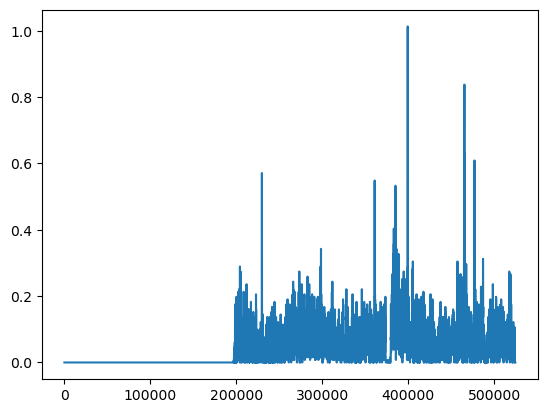

In [145]:
import matplotlib.pyplot as plt
plt.plot(data)

In [149]:
data.shape

torch.Size([524288])

In [ ]:
mask_data, unmask_data = mask_seq(data, mask_pct=0.15, replace_with_N=False, span=500, stype='acc')
print(mask_data.shape) #should be length x 6, so 5 for the one hot and 1 for the mask track
print(unmask_data.shape)

#ahh need to account for if span is less, then when we append extra elemments on, it has to make it the right size, primarily just for masked indices
#for the rest it's fine, never need to idnex xinto the end

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 524288 but got size 524000 for tensor number 1 in the list.

In [ ]:
def mask_seq(seq, mask_pct=0.15, replace_with_N=False, span=1, stype='seq'):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, 5) if one hot encoding, or (length,) if not one hot and is accessibility data
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'seq' for nucleotide data and 'acc' for accessibility data, default is 'seq'
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, 6) if one hot encoding or (length, 2) if acc, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, 6) if ohe or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """

    if replace_with_N:
        random_max = 5
    else:
        random_max = 4
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    masked_indices = torch.bernoulli(probability_matrix).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()*span #squeeze to remove the extra dimension, and multiply by span to get the actual positions in the original sequence
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is

    if span > 1:
        masked_indices = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        #and append zeros until the size of seq
        extra = seq.shape[0] % span
        if extra > 0:
            masked_indices = torch.cat([masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        #now for each of the positions, we need to expand and then make masking apply per index
        mask_positions = (mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        random_positions = (random_positions.unsqueeze(1) + torch.arange(span)).flatten()
        unchanged_positions = (unchanged_positions.unsqueeze(1) + torch.arange(span)).flatten()
        #and now they are grouped and we can just deal with them

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6], or [seq_len, 2] if acc data
    # where the last column is the mask track
    # print(seq.shape, masked_indices.shape)
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    if stype == 'seq':
        random_tokens = torch.randint(0, random_max, (random_positions.numel(),)) #generate random values for each position
        random_one_hot = torch.zeros((random_positions.numel(), 5)) #one hot encode them
        random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
        seq_masked[random_positions, :5] = random_one_hot #assign them to the set positions
        
    elif stype == 'acc':
        #for accessibility, we will select random values from somewhere else in the sequence and then slightly shift and noise them
        #get a random value between 0 and len(seq)-span
        rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel()//span,))
        rand_idx = (rand_start.unsqueeze(1) + torch.arange(span)) #so now we have a random index for each of the random positions, and we can just select from there
        rand_vals = seq.squeeze(1)[rand_idx] #get the values from the sequence at those random positions, so now we have a random value for each of the random positions
        #and we can add some noise to it, so we can just add a small random value to it. Noise will be values between -0.1 and 0.1
        rand_vals_mean = rand_vals.mean(1, keepdim=True) #get the mean of the random values for each position, keeps the dim so we can broadcast it
        noise = torch.randn(rand_vals.shape) * rand_vals_mean * 0.1 #gaussian noise with std of 0.1 times the mean of the random values, so we can add some larger nosie to larger values
        rand_vals = (rand_vals + noise).flatten()
        #and now set the values
        seq_masked[random_positions, 0] = rand_vals #set the values to the random values with noise, so now we have a random value for each of the random positions
    
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing

mask_data, unmask_data = mask_seq(data, mask_pct=0.15, replace_with_N=False, span=500, stype='acc')


torch.Size([524288, 1]) torch.Size([524288])


In [161]:
#full funciton again

def mask_seq(seq, mask_pct=0.15, replace_with_N=False, span=1, stype='seq'):
    """This function will mask the sequence data, it does the BERT masking where you do 80% truly masked, 10% random, 10% unchanged
    Note that for random replacement, it cannot be the N token, sicne it's very rare anyways, always random nucleotide!
    Args:
        seq: the sequence to mask, this is a tensor of shape (length, 5) if one hot encoding, or (length,) if not one hot and is accessibility data
        mask_pct: the percentage of the sequence to mask, default is 0.15 or 15%
        replace_with_N: whether to allow random replacement of values with N
        span: the size of the span to mask, default is 1, so it masks every element independently, but can be larger to mask chunks of size span
        stype: the type of sequence, 'seq' for nucleotide data and 'acc' for accessibility data, default is 'seq'
    Returns:
        seq: the masked sequence, this is a tensor of shape (length, 6) if one hot encoding or (length, 2) if acc, where the last column is the mask track (only tells if masked, some are random or unchanged)
        seq_unmask: the unmasked sequence, this is a tensor of shape (length, 6) if ohe or (length, 2), where the last column is the mask track (tells all elements that have been changed or goign to evaluate)
    """

    if replace_with_N:
        random_max = 5
    else:
        random_max = 4
    
    num_elements = seq.shape[0]//span #chunks into chunks of size span
    
    if len(seq.shape) == 1: #if it's just a 1D tensor, we need to add a dimension for the mask track
        seq = seq.unsqueeze(1) #so now it's shape length x 1, so we can concatenate other things
    
    # Create a probability vector (one per token) and sample which tokens to mask
    probability_matrix = torch.full((num_elements,), mask_pct) #size of length, defines for each element if we mask it or not
    masked_indices = torch.bernoulli(probability_matrix).bool() #finds which indices to mask, so shape is length, and is True or False for each index

    # Get positions that were chosen to be masked
    all_mask_positions = torch.nonzero(masked_indices).squeeze()*span #squeeze to remove the extra dimension, and multiply by span to get the actual positions in the original sequence
    num_masked = all_mask_positions.numel()
    
    # Determine counts for the three groups: 80% truly masked, 10% random, 10% unchanged
    num_mask = int(0.8 * num_masked)
    num_random = int(0.1 * num_masked)
    # To avoid rounding issues, let the remaining be unchanged
    # num_unchanged = num_masked - num_mask - num_random
    
    # Shuffle the masked positions to randomly assign each to a category
    permuted = all_mask_positions[torch.randperm(num_masked)]
    mask_positions = permuted[:num_mask]  # 80%: replace with mask token
    random_positions = permuted[num_mask:num_mask+num_random]  # 10%: random token
    unchanged_positions = permuted[num_mask+num_random:]  # 10%: leave as is

    if span > 1:
        masked_indices = masked_indices.repeat_interleave(span) #so now we have a mask for every element in the span, so size length again
        #and append zeros until the size of seq
        extra = seq.shape[0] % span
        if extra > 0:
            masked_indices = torch.cat([masked_indices, torch.zeros(extra, dtype=torch.bool)]) #so now we have a mask for every element in the span, so size length again
        
        #now for each of the positions, we need to expand and then make masking apply per index
        mask_positions = (mask_positions.unsqueeze(1) + torch.arange(span)).flatten()
        random_positions = (random_positions.unsqueeze(1) + torch.arange(span)).flatten()
        unchanged_positions = (unchanged_positions.unsqueeze(1) + torch.arange(span)).flatten()
        #and now they are grouped and we can just deal with them

    # Append the mask track to the sequence, resulting in a tensor of shape [seq_len, 6], or [seq_len, 2] if acc data
    # where the last column is the mask track
    seq_unmask = torch.cat([seq, masked_indices.unsqueeze(1).float()], dim=1) #so now seq_unmask is shape length x 6, where 6 is the 5 one hot classes and the mask
    
    seq_masked = seq_unmask.clone()  # Create a copy to modify, note that the mask track should be 0 for ones where it's not masked but is random or unchanged
    seq_masked[mask_positions, :-1] = 0  # Set to zero for every class but the last (tells it it's masked)
    
    if stype == 'seq':
        random_tokens = torch.randint(0, random_max, (random_positions.numel(),)) #generate random values for each position
        random_one_hot = torch.zeros((random_positions.numel(), 5)) #one hot encode them
        random_one_hot.scatter_(1, random_tokens.unsqueeze(1), 1.0)
        seq_masked[random_positions, :5] = random_one_hot #assign them to the set positions
        
    elif stype == 'acc':
        #for accessibility, we will select random values from somewhere else in the sequence and then slightly shift and noise them
        #get a random value between 0 and len(seq)-span
        rand_start = torch.randint(0, seq.shape[0]-span, (random_positions.numel()//span,))
        rand_idx = (rand_start.unsqueeze(1) + torch.arange(span)) #so now we have a random index for each of the random positions, and we can just select from there
        rand_vals = seq.squeeze(1)[rand_idx] #get the values from the sequence at those random positions, so now we have a random value for each of the random positions
        #and we can add some noise to it, so we can just add a small random value to it. Noise will be values between -0.1 and 0.1
        rand_vals_mean = rand_vals.mean(1, keepdim=True) #get the mean of the random values for each position, keeps the dim so we can broadcast it
        noise = torch.randn(rand_vals.shape) * rand_vals_mean * 0.1 #gaussian noise with std of 0.1 times the mean of the random values, so we can add some larger nosie to larger values
        rand_vals = torch.clamp((rand_vals + noise).flatten(), min=0)
        #and now set the values
        seq_masked[random_positions, 0] = rand_vals #set the values to the random values with noise, so now we have a random value for each of the random positions
    
    #and remove the masked value, it doesn't know it's masked
    seq_masked[random_positions, -1] = 0
    
    #and we remove the mask token from the unchanged value
    seq_masked[unchanged_positions, -1] = 0
    # seq = seq_masked #now we have the masked sequence, so we can use this for the rest of the processing
    
    return seq_masked, seq_unmask #return the masked sequence and the unmasked sequence, so we can use it for the rest of the processing

mask_data, unmask_data = mask_seq(data, mask_pct=0.15, replace_with_N=False, span=500, stype='acc')
print(mask_data.shape) #should be length x 2, see if it makes sense
print(unmask_data.shape)

torch.Size([524288, 2])
torch.Size([524288, 2])


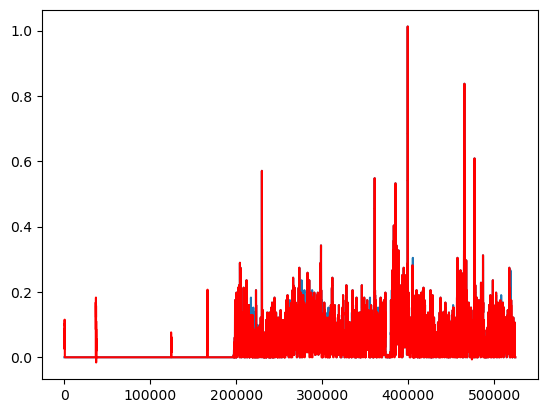

In [ ]:
#and let's test if it makes sense with a plot
plt.plot(data)
plt.plot(mask_data[:, 0], 'r') #masked data should be red
#there will obviously be regions where it differs, and lots of random regions like you see 

In [ ]:
#let's test the speed of the masking
for i in range(100):
    # seq,data = dataset[1022]
    # data = data.squeeze(1) #remove the extra dimension so it's shape (length,)
    mask_data, unmask_data = mask_seq(data, mask_pct=0.15, replace_with_N=False, span=500, stype='acc')
#literally 0.4 seconds, I think the other one might be slower?

In [164]:
seq.shape

torch.Size([5, 524288])

In [165]:
#let's test both
tempseq = seq.transpose(1,0)
for i in range(100):
    a,b = mask_seq(tempseq, mask_pct=0.15, replace_with_N=False,stype='seq')
    a,b = mask_seq(data, mask_pct=0.15, replace_with_N=False, span=500, stype='acc')
#yeah the normal masking is the slower one, quite a bit actually??

In [167]:
from tqdm import tqdm
for i in tqdm(range(100)):
    a,b = mask_seq(tempseq, mask_pct=0.15, replace_with_N=False,stype='seq')

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


In [168]:
for i in tqdm(range(100)):
    a,b = mask_seq(data, mask_pct=0.15, replace_with_N=False, span=500, stype='acc')

100%|██████████| 100/100 [00:01<00:00, 51.10it/s]


In [ ]:
#well maybe the slow part is the bernoulli or maybe it's something else, regardless like 0.1 seconds per thing, so we're fine! 

# final thing, reset the thing, reimport it and tell it to do the masking, see what happens!!

In [ ]:
from tqdm import tqdm
import torch
from src.dataloaders.datasets.general_dataset import GeneralDataset
#all done in a new file, this is too many cells